# Figure 7: Synthetic single-proxy inference
This notebook can be used to: 
- Load and plot the synthetic d13C and age constraint data (as in Fig. 7a)
- Build and sample the inference model
- Load the inference results from the model run used to produce Fig. 7b-c
- Visualize the results using functions from `stratmc.plotting`
- Reproduce Fig. 7 using these data

In [1]:
%load_ext autoreload
%autoreload 2

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

import stratmc

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Avenir"]
rcParams.update({"text.usetex": False})

import warnings

from scipy.ndimage import gaussian_filter as gaussian
from scipy.stats import gaussian_kde

warnings.simplefilter(action="ignore", category=FutureWarning)

## Synthetic d13C signal and data

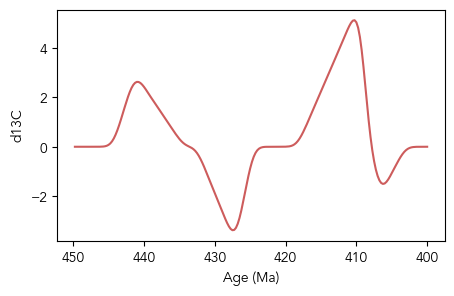

In [2]:
age_vector = np.arange(400, 450, 0.25)
amplitude = [3, -4, 6, -2]
d13c_signal = stratmc.synthetics.make_excursion(
    age_vector,
    amplitude,
    excursion_duration=[10, 8, 10, 5],
    rising_time=[0.3, 0.7, 0.9, 0.3],
    smooth=True,
    smoothing_factor=2,
    rate_offset=True,
    seed=7,
)

d13c_signal = gaussian(np.flip(d13c_signal), 3)

signal_dict = {}
signal_dict["d13c"] = d13c_signal

fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.plot(age_vector, d13c_signal, color="indianred")

ax.invert_xaxis()
ax.set_xlabel("Age (Ma)")
ax.set_ylabel("d13C");

In [3]:
# Load the synthetic proxy observations
sample_df = stratmc.data.load_object("data/Fig7_synthetic_sample_df_single_proxy")
ages_df = stratmc.data.load_object("data/Fig7_synthetic_ages_df_single_proxy")

sections = np.unique(sample_df["section"].values)

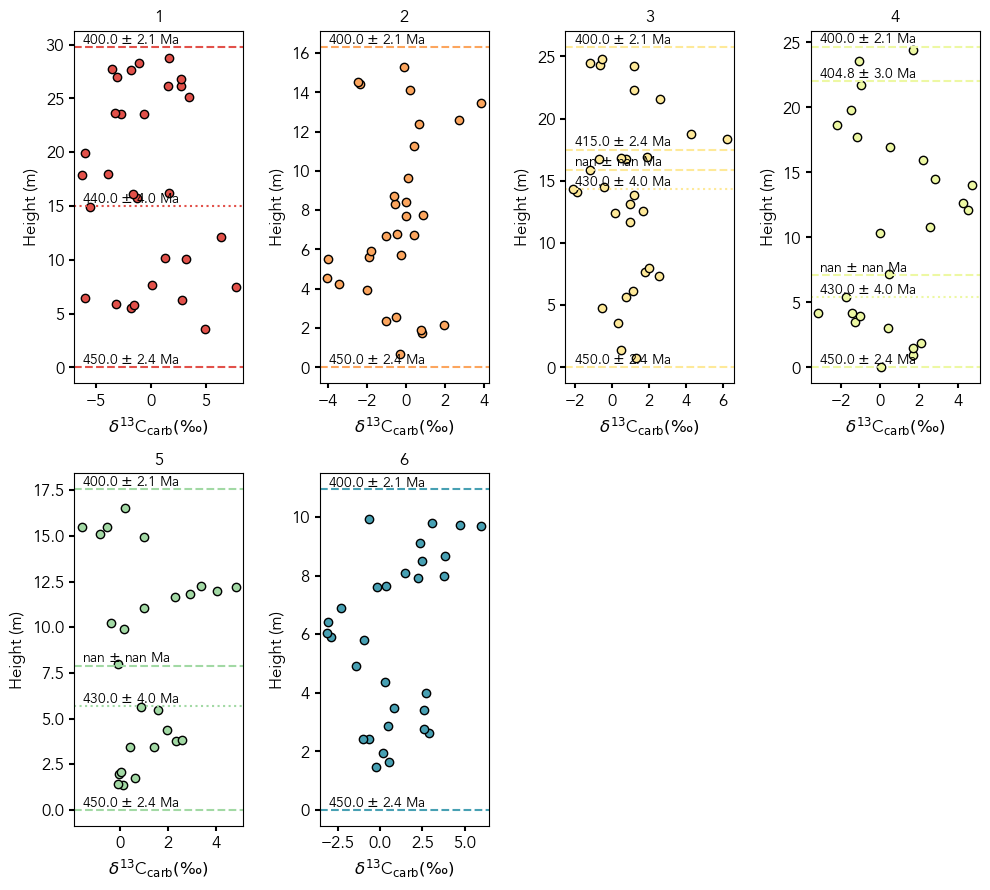

In [4]:
# Plot the d13C observations with stratmc.plotting.proxy_strat
fig = stratmc.plotting.proxy_strat(sample_df, ages_df)

## Synthetic lithostratigraphy (Fig. 7a)

In [5]:
facies_colors = {}
facies_widths = {}

facies_colors["limestone"] = "#F4F2F3"
facies_colors["diamictite"] = "gray"

facies_widths["limestone"] = 0.75
facies_widths["diamictite"] = 1

section_facies = {}
section_facies_thicknesses = {}

# section 1
section_facies["1"] = ["limestone"]
section_facies_thicknesses["1"] = [np.max(ages_df[ages_df["section"] == "1"]["height"])]

# section 2
section_facies["2"] = ["limestone"]
section_facies_thicknesses["2"] = [np.max(ages_df[ages_df["section"] == "2"]["height"])]

# section 3
# diamictite at 14.35-15.9 meters
section_facies["3"] = ["limestone", "diamictite", "limestone"]
section_facies_thicknesses["3"] = [
    14.35,
    15.9 - 14.35,
    np.max(ages_df[ages_df["section"] == "3"]["height"]) - 15.9,
]

# section 4
# diamictite at 5.4-7.1 meters
section_facies["4"] = ["limestone", "diamictite", "limestone"]
section_facies_thicknesses["4"] = [
    5.4,
    7.1 - 5.4,
    np.max(ages_df[ages_df["section"] == "4"]["height"]) - 7.1,
]

# section 5
# diamictite at 5.7-7.9 meters
section_facies["5"] = ["limestone", "diamictite", "limestone"]
section_facies_thicknesses["5"] = [
    5.7,
    7.9 - 5.7,
    np.max(ages_df[ages_df["section"] == "5"]["height"]) - 7.9,
]

# section 6
section_facies["6"] = ["limestone"]
section_facies_thicknesses["6"] = [np.max(ages_df[ages_df["section"] == "6"]["height"])]

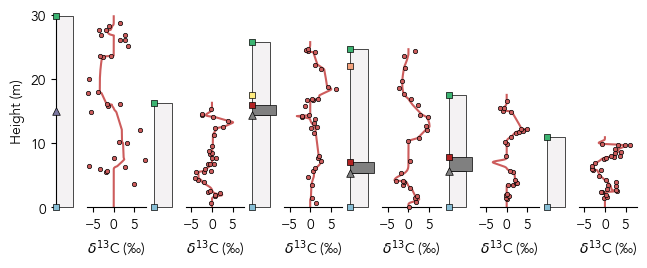

In [6]:
fs = 10

d13c_sections = np.unique(sample_df["section"][~np.isnan(sample_df["d13c"])])

widths = [0.4, 1] * 6

fig, ax = plt.subplots(
    1,
    2 * 6,
    figsize=(7.5, 2.5),
    sharey=False,
    sharex=False,
    gridspec_kw={"width_ratios": widths},
)

for i in np.arange(len(d13c_sections)):
    section = d13c_sections[i]

    section_ages_df = ages_df[
        (ages_df["section"] == section)
        & (~np.isnan(ages_df["age"]))
        & (~ages_df["intermediate detrital?"])
    ]
    section_df = sample_df[sample_df["section"] == section]

    sec_sample_ages = sample_df[sample_df["section"] == section]["age"].values
    sec_sample_heights = sample_df[sample_df["section"] == section]["height"].values

    sec_radio_ages = section_ages_df["age"].values
    sec_ages_comb = np.concatenate([sec_radio_ages, section_df["age"]])

    heights_comb = np.concatenate([section_ages_df["height"], section_df["height"]])

    heights_comb_sort_idx = np.argsort(heights_comb)

    sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
    heights_comb = heights_comb[heights_comb_sort_idx]

    d13c_section_interp = np.interp(sec_ages_comb, age_vector, d13c_signal)

    new_heights = np.linspace(np.min(heights_comb), np.max(heights_comb), 200)
    sec_age_interp = np.interp(new_heights, heights_comb, sec_ages_comb)

    d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)

    ax[i * 2 + 1].plot(d13c_section_interp, new_heights, c="indianred", zorder=0)

    ax[i * 2 + 1].scatter(
        sample_df[sample_df["section"] == section]["d13c"],
        sample_df[sample_df["section"] == section]["height"],
        color="indianred",
        edgecolor="k",
        s=10,
        lw=0.5,
        clip_on=False,
        zorder=10,
    )

    section_ages_df = ages_df[ages_df["section"] == section]

    for j in np.arange(section_ages_df.shape[0]):
        if j == 0:  # base of sections
            age_color = "#87BED5"

        if j == section_ages_df.shape[0] - 1:  # top of sections
            age_color = "mediumseagreen"

        if list(section_ages_df.index)[j] == 1:
            age_color = "#7C78A0"  # purple DZ

        if list(section_ages_df.index)[j] in [6, 11, 16]:  # diamictite base
            age_color = "gray"

        if list(section_ages_df.index)[j] == 8:
            age_color = "#FFEB7F"  # yellow - section 3 depositional age

        if list(section_ages_df.index)[j] == 13:  # orange - section 4 depositional age
            age_color = "#F4A27C"

        if list(section_ages_df.index)[j] in [7, 12, 17]:  # diamictite top
            age_color = "firebrick"

        if section_ages_df.iloc[j]["intermediate detrital?"]:
            ax[i * 2].scatter(
                0,
                section_ages_df.iloc[j]["height"],
                color=age_color,
                marker="^",
                edgecolor="k",
                s=30,
                lw=0.5,
                zorder=10,
                clip_on=False,
            )

        else:
            ax[i * 2].scatter(
                0,
                section_ages_df.iloc[j]["height"],
                color=age_color,
                edgecolor="k",
                marker="s",
                s=25,
                lw=0.5,
                zorder=10,
                clip_on=False,
            )

        ax[i * 2].set_xlim([0, 1])

    current_base = 0
    for facies, thickness in zip(
        section_facies[section], section_facies_thicknesses[section]
    ):
        ax[i * 2].barh(
            y=current_base,
            width=facies_widths[facies],
            height=thickness,
            linewidth=0.5,
            edgecolor="k",
            align="edge",
            color=facies_colors[facies],
            clip_on=False,
        )
        current_base += thickness

    ax[i * 2].set_yticklabels([])


_ = [ax[i].sharex(ax[1]) for i in [3, 5, 7, 9, 11]]
_ = [ax[i].sharey(ax[0]) for i in np.arange(1, 12)]

ax[1].set_xlim([np.min(sample_df["d13c"]) - 0.1, np.max(sample_df["d13c"]) + 0.1])

ax[1].set_ylim([0, np.max(ages_df["height"])])

for i in [0, 2, 4, 6, 8, 10]:  # [1, 3, 5, 7, 9, 11]:#[0, 2, 4, 6, 8, 10]:
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].set_xlim([0, 1])
    ax[i].set_xticks([])

for i in [1, 3, 5, 7, 9, 11]:
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(False)
    ax[i].set_xlabel("$\delta^{13}$C (‰)", fontsize=fs)


for axis in ax.ravel():
    axis.set_axisbelow(True)
    axis.set_yticks([])
    axis.tick_params(labelsize=fs)

ax[0].tick_params(labelsize=fs)


ax[0].spines["left"].set_visible(True)
ax[0].set_ylabel("Height (m)", fontsize=fs)

ax[0].set_yticks([0, 10, 20, 30])
ax[0].set_yticklabels([0, 10, 20, 30])

for i in np.arange(1, 12):
    [t.set_color("none") for t in ax[i].yaxis.get_ticklabels()]
    ax[i].tick_params(axis="y", color="none")

## Build the inference model and sample the posterior
To load the results for the inference used to produce Fig. 7, skip to [Load the inference results](#Load-the-inference-results). 

In [7]:
model, gp = stratmc.model.build_model(
    sample_df,
    ages_df,
    proxies=["d13c"],
    ls_dist="Wald",
    ls_min=3,  # minimum RBF kernel lengthscale
    ls_mu=10,  # mean of Wald distribution used as RBF kernel lengthscale prior
    ls_lambda=25,  # lambda of Wald distribution used as RBF kernel lengthscale prior
    offset_type="section",  # per-section offset with default prior
    noise_type="section",  # per-section noise with default prior
)

Using radiometric age priors specified in ages_df for section 3
Using radiometric age priors specified in ages_df for section 4
Using radiometric age priors specified in ages_df for section 5


In [94]:
# vector of ages at which to evaluate the proxy sigal
age_min = 400
age_max = 450

predict_ages = np.arange(age_min, age_max + 0.5, 0.5)[:, None]

extension = "Fig7_synthetic_single_proxy"

full_trace = stratmc.inference.get_trace(
    model,
    gp,
    predict_ages,
    sample_df,
    ages_df,
    proxies=["d13c"],
    name=extension,
    chains=100,
    draws=1000,
    tune=2000,
    target_accept=0.9,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

There were 298 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/staceyedmonsond/Dropbox/stratmc/stratmc/inference.py:152: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  
Sampling: [f_pred_d13c]


Output()

/Users/staceyedmonsond/Dropbox/stratmc/stratmc/inference.py:159: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  random_seed = seed
Sampling: [1_0_detrital_age_0, 1_0_scaling_factor_1, 1_0_scaling_factor_2, 1_0_unsorted_random_ages, 1_flip_radiometric_age, 1_section_noise_d13c, 1_section_offset_d13c, 2_0_scaling_factor_1, 2_0_scaling_factor_2, 2_0_unsorted_random_ages, 2_flip_radiometric_age, 2_section_noise_d13c, 2_section_offset_d13c, 3_0_radiometric_age, 3_0_scaling_factor_1, 3_0_scaling_factor_2, 3_0_unsorted_random_ages, 3_1_scaling_factor_1, 3_1_scaling_factor_2, 3_1_unsorted_random_ages, 3_2_radiometric_age, 3_2_scaling_factor_1, 3_2_scaling_factor_2, 3_2_unsorted_random_ages, 3_3_radiometric_age, 3_section_noise_d13c, 3_section_offset_d13c, 4_0_radiometric_age, 4_0_scaling_factor_1, 4_0_scaling_factor_2, 4_0_unsorted_random_ages, 4_1_scaling_factor_1, 4_1_sca

## Load the inference results
Load the trace used to produce Fig. 7b-c 

In [8]:
full_trace = stratmc.data.load_trace("traces/" + "Fig7_synthetic_single_proxy")

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


## Plot the inference results with `stratmc.plotting`

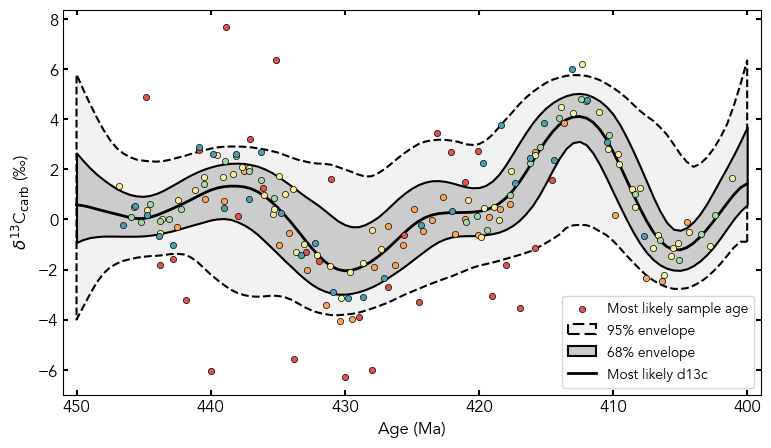

In [8]:
# Plot the proxy signal inference
fig = stratmc.plotting.proxy_inference(sample_df, ages_df, full_trace, plot_data=True)

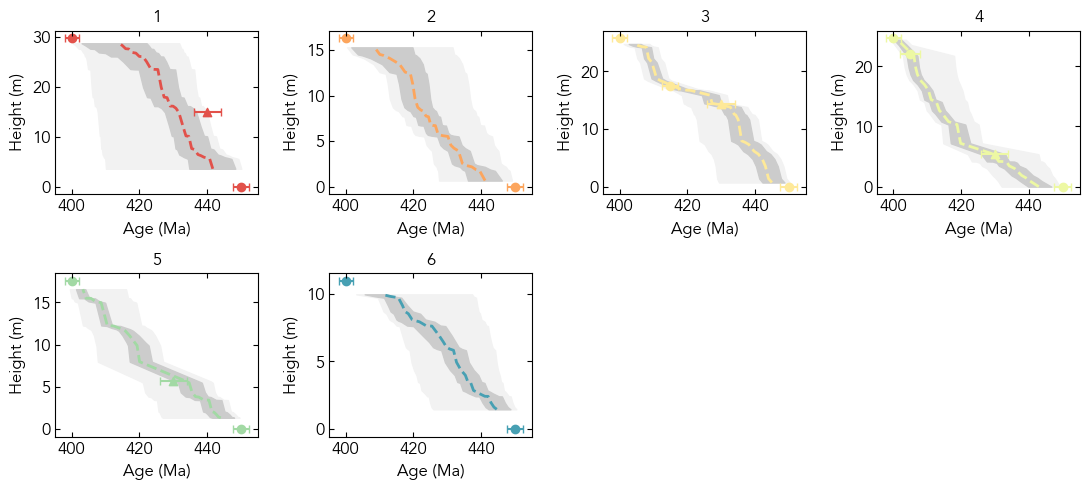

In [11]:
# Plot the posterior age model for each section
fig = stratmc.plotting.age_height_model(sample_df, ages_df, full_trace, legend=False)

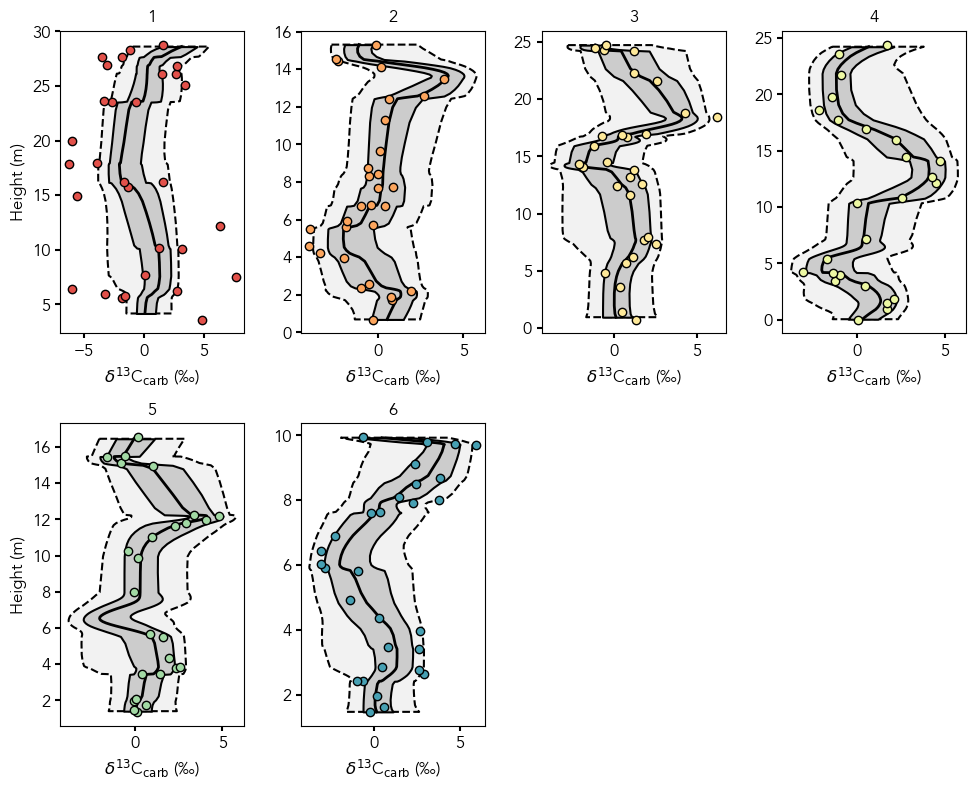

In [9]:
# Map the proxy signal back to height in each section using the most likely posterior age models
fig = stratmc.plotting.section_proxy_signal(full_trace, sample_df, ages_df)

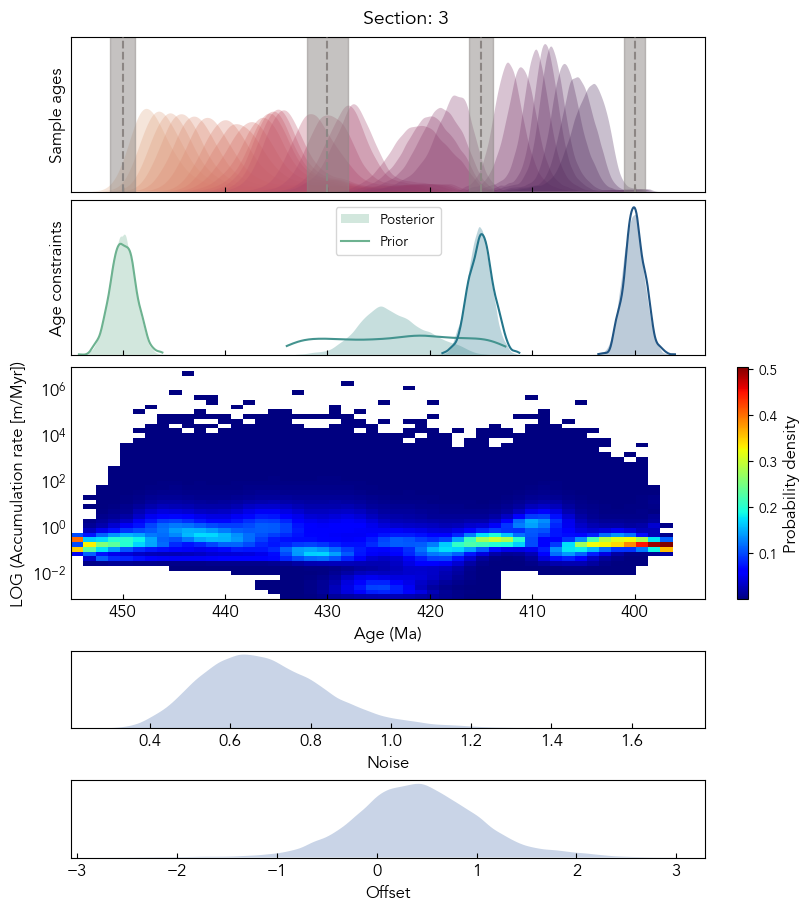

In [10]:
# Take a closer look at Section 3
fig = stratmc.plotting.section_summary(sample_df, ages_df, full_trace, section="3")

## Fig. 7b-c

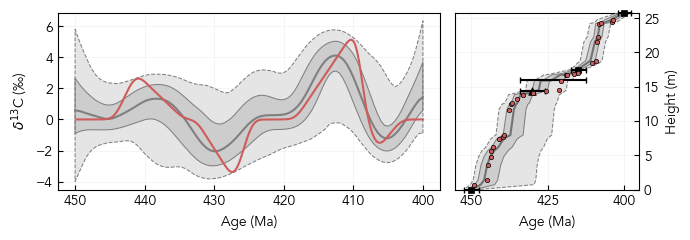

In [11]:
mosaic = """
    111111222
    111111222
    """

fs = 10
fig, ax = plt.subplot_mosaic(
    mosaic, figsize=(7, 2.5), sharex=False, sharey=False, constrained_layout=False
)


# plot the posterior d13C signal with 68 and 95% envelopes
ages = full_trace.X_new.X_new.values
proxy_pred = az.extract(full_trace.posterior_predictive)["f_pred_" + "d13c"].values

hi = np.percentile(proxy_pred, 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred, 2.5, axis=1).flatten()

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,  # 1.5
    zorder=1,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=2,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred, 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred, 16, axis=1).flatten()

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=4,
)

ax["1"].fill_between(
    ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,  # 1.5
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred), np.max(proxy_pred), 200)
max_like = np.zeros(ages.size)
for i in np.arange(ages.size):
    time_slice = proxy_pred[i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]

max_like = gaussian(max_like, 2)
ax["1"].plot(
    ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax["1"].plot(age_vector, d13c_signal, color="indianred", label="True Signal", zorder=10)

ax["1"].invert_xaxis()
ax["1"].set_xlim([np.max(ages) + 2.5, np.min(ages) - 2.5])

ax["1"].set_ylabel("$\delta^{13}$C (‰)", fontsize=fs)
ax["1"].set_xlabel("Age (Ma)", fontsize=fs)


for k in list(ax.keys()):
    ax[k].tick_params(direction="in", labelsize=fs)
    ax[k].set_axisbelow(True)
    ax[k].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)


# example age-height model for section 3
section = "3"
section_df = sample_df[sample_df["section"] == section]

sample_heights = section_df["height"]
age_heights = ages_df[
    (ages_df["section"] == section)
    & (~ages_df["intermediate detrital?"])
    & (~ages_df["intermediate intrusive?"])
]["height"]

sample_age_var = str(section) + "_ages"
radiometric_age_var = str(section) + "_radiometric_age"

comb = np.concatenate([sample_heights, age_heights])
sort_idx = np.argsort(comb)

sample_posterior = az.extract(full_trace.posterior)[str(section) + "_ages"].values
age_posterior = az.extract(full_trace.posterior)[
    str(section) + "_radiometric_age"
].values

posterior_stacked = np.vstack([sample_posterior, age_posterior])[sort_idx, :]

lo = np.percentile(posterior_stacked, 2.5, axis=1).flatten()
hi = np.percentile(posterior_stacked, 97.5, axis=1).flatten()


ax["2"].fill_betweenx(
    comb[sort_idx],
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,  # 1.5
    zorder=1,
)

ax["2"].fill_betweenx(
    comb[sort_idx],
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=2,
)

ax["2"].fill_betweenx(
    comb[sort_idx],
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,  # 1.5
    zorder=3,
)

hi = np.percentile(posterior_stacked, 100 - 16, axis=1).flatten()

lo = np.percentile(posterior_stacked, 16, axis=1).flatten()

ax["2"].fill_betweenx(
    comb[sort_idx],
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=4,
)

ax["2"].fill_betweenx(
    comb[sort_idx],
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,  # 1.5
    zorder=5,
)

max_like = np.zeros(posterior_stacked.shape[0])
for j in np.arange(posterior_stacked.shape[0]):
    sample_ages = posterior_stacked[j, :]
    dx = np.linspace(np.min(sample_ages), np.max(sample_ages), 1000)
    max_like[j] = dx[np.argmax(gaussian_kde(sample_ages, bw_method=1)(dx))]

label = "_nolegend_"

ax["2"].plot(
    max_like,
    comb[sort_idx],
    color="gray",
    label="Most likely age model",
    lw=1.5,
    linestyle="solid",
    zorder=3,
)

ax["2"].errorbar(
    ages_df["age"][ages_df["section"] == section],
    ages_df["height"][ages_df["section"] == section],
    xerr=2 * ages_df["age_std"][ages_df["section"] == section],
    color="k",
    fmt="none",
    capsize=2,
    zorder=5,
    clip_on=False,
)

section_ages_df = ages_df[ages_df["section"] == section]
ax["2"].scatter(
    section_ages_df["age"][
        (~section_ages_df["intermediate intrusive?"])
        & (~section_ages_df["intermediate detrital?"])
    ],
    section_ages_df["height"][
        (~section_ages_df["intermediate intrusive?"])
        & (~section_ages_df["intermediate detrital?"])
    ],
    color="k",
    marker="s",
    lw=0.5,
    edgecolor="k",
    s=25,
    zorder=6,
    label="Age constraint ($\pm2\sigma$)",
    clip_on=False,
)


if section_ages_df["age"][section_ages_df["intermediate intrusive?"]].shape[0] > 0:
    ax["2"].scatter(
        section_ages_df["age"][section_ages_df["intermediate intrusive?"]],
        section_ages_df["height"][section_ages_df["intermediate intrusive?"]],
        marker=">",
        s=25,
        zorder=5,
        color="k",
        label="Intrusive Age ($\pm2\sigma$)",
        clip_on=False,
    )

if section_ages_df["age"][section_ages_df["intermediate detrital?"]].shape[0] > 0:
    ax["2"].scatter(
        section_ages_df["age"][section_ages_df["intermediate detrital?"]],
        section_ages_df["height"][section_ages_df["intermediate detrital?"]],
        marker="^",
        s=30,
        zorder=6,
        lw=0.5,
        color="black",
        label="Detrital Age ($\pm2\sigma$)",
        clip_on=False,
    )

uniform_lower = section_ages_df[section_ages_df["distribution_type"] == "Uniform"][
    "param_1"
].values
uniform_upper = section_ages_df[section_ages_df["distribution_type"] == "Uniform"][
    "param_2"
].values
uniform_height = section_ages_df[section_ages_df["distribution_type"] == "Uniform"][
    "height"
].values


ax["2"].errorbar(
    (uniform_lower + uniform_upper) / 2,
    uniform_height,
    zorder=5,
    xerr=(uniform_upper - uniform_lower) / 2,
    capsize=2,
    color="k",
    fmt="none",
    clip_on=False,
)

ax["2"].scatter(
    section_df["age"],
    section_df["height"],
    color="indianred",
    edgecolor="k",
    s=10,
    lw=0.5,
    zorder=10,
    label="True sample age",
)

ax["2"].invert_xaxis()
ax["2"].yaxis.tick_right()
ax["2"].yaxis.set_label_position("right")

ax["2"].axis("tight")
ax["2"].set_xlabel("Age (Ma)", fontsize=fs)
ax["2"].set_ylabel("Height (m)", fontsize=fs)

ax["2"].tick_params(
    bottom=True, top=False, left=False, right=True, direction="in", labelsize=fs
)
ax["2"].set_xticks([450, 425, 400])


ax["2"].set_ylim([0, np.max(ages_df["height"][ages_df["section"] == section])])

fig.tight_layout()